In [417]:
from pydantic import BaseModel
import pandas as pd 
import os
from dotenv import load_dotenv
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode
load_dotenv()
import os 
from langchain_core.messages import HumanMessage, SystemMessage
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")
os.environ["GOOGLE_API_KEY"] = os.getenv("GOOGLE_API_KEY")
os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")
os.environ["GOOGLE_SERPER_API_KEY"] = os.getenv("SERPER_API_KEY")
from typing import Annotated, Literal, TypedDict

import bs4

from langchain import hub
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import FAISS
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough,RunnableLambda
from langchain_google_genai import ChatGoogleGenerativeAI,GoogleGenerativeAIEmbeddings
from langchain_groq import ChatGroq
from langchain.retrievers import ContextualCompressionRetriever
from langchain.retrievers.document_compressors import FlashrankRerank
from langchain.utilities import GoogleSerperAPIWrapper
from langchain.load import dumps, loads
from langchain.prompts import PromptTemplate,ChatPromptTemplate
from langchain_google_genai import GoogleGenerativeAIEmbeddings,ChatGoogleGenerativeAI
embeddings = GoogleGenerativeAIEmbeddings(model="models/embedding-001")
# llm = ChatGoogleGenerativeAI(
#     model="gemini-1.5-pro",
#     temperature=0,
#     max_tokens=None,
#     timeout=None,
#     max_retries=2,
#     # other params...
# )
llm = ChatGroq(temperature=0, model_name="Gemma2-9b-It")
from langgraph.graph.message import add_messages
from pydantic import BaseModel,Field
from langchain_core.tools import tool
from langgraph.graph import StateGraph,MessagesState,END
from langgraph.prebuilt import ToolNode
from langchain_core.messages import HumanMessage
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
from langgraph.graph import START,END

import random
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import AIMessage,HumanMessage

In [418]:
from langgraph.checkpoint.memory import MemorySaver


In [419]:
class Contactinfo(BaseModel):
    name:str |None=None
    phone:int  | None=None
    email:str  | None=None
    

In [420]:
class info(BaseModel):
    userInfo:list[Contactinfo]=Field(
        description="Comprehensive list of analysis with their roles and affiliations."
    )
    

In [421]:
class userIntent(BaseModel):
    intent:int

In [ ]:
class getuserInfo(MessagesState):
    input: str
    Contactinfo: Contactinfo
    extracted_info:str
    missing_fields:list[str]
    userintent:userIntent
    booked_date:str
    


In [423]:
class date(BaseModel):
    date:str

In [424]:
from langgraph.constants import Send

In [425]:
user_intent_finder_prompt= """You are a helpful AI assistant whose task is to classify user messages into three distinct categories. Analyze the user's message and respond with only a single number (0, 1, or 2) based on these rules:

Return 0 if:
- User wants to call or contact you
- User requests a phone conversation
- User asks for direct communication
- User wants to have a voice chat
Examples: "I want to call you", "can you contact me", "let's have a call", "can we talk on phone?"

Return 1 if:
- User wants to book an appointment
- User asks about scheduling a meeting
- User wants to make a reservation
Examples: "book an appointment", "I need to schedule a meeting", "make a reservation"

Return 2 if:
- User asks general questions about the context
- User requests information or assistance
- User wants to have a text conversation
- Any other message that doesn't fit categories 0 or 1
Examples: "what is machine learning?", "help me with my homework", "explain quantum physics"

Input: {input}

Remember to see the input and then decidee."""

def getuserintent(state:getuserInfo):
    input=state["input"]
    llm_structured_output=llm.with_structured_output(userIntent)
    system_message=user_intent_finder_prompt.format(input=input)
    result=llm_structured_output.invoke([SystemMessage(content=system_message)])
    return {"userintent":result.intent}

# def userintents(state:getuserInfo):
#     result=state.get("userintent")
#     userintents=result.intent
#     if userintents == 0:
#        return "extract"
#     elif userintents == 1:
#         return "booking_node"
#     else:
#         return "rag_node"
    
    
    



In [426]:
from datetime import datetime

# Get today's date with the day of the week
today_date= datetime.today().strftime('%Y-%m-%d (%A)')


In [427]:
user_response_prompt="""The user wants to book an appointment.. 
Your task is to:
1. Parse this request and return ONLY a date in YYYY-MM-DD format
2. Today date is {today_date}
3. If the day has already passed this week, assume they mean next week
4. Return ONLY the date, no other text

The input user is this : {user_input}
"""

In [428]:
from langchain_community.document_loaders import PyPDFLoader
loader=PyPDFLoader("ndc.pdf")
docs=loader.load()

text_splitter=RecursiveCharacterTextSplitter(chunk_size=1000,chunk_overlap=20)
documents=text_splitter.split_documents(docs)

In [429]:
from langchain.retrievers import BM25Retriever, EnsembleRetriever
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain.chains.retrieval import create_retrieval_chain

In [430]:
from langchain_community.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores import FAISS
from langchain.retrievers import BM25Retriever, EnsembleRetriever
from langchain.prompts import ChatPromptTemplate
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain.chains.retrieval import create_retrieval_chain

class AnswerRAG:
    def __init__(self, pdf_path="ndc.pdf", llm=llm, embeddings=embeddings):
        """
        Initialize the RAG system with PDF path, LLM, and embeddings model
        """
        self.llm = llm
        self.embeddings = embeddings
        
        # Load and process documents
        self.documents = self._process_pdf(pdf_path)
        
        # Initialize retrievers
        self.vectorstore = FAISS.from_documents(self.documents, self.embeddings)
        self.retriever_vectordb = self.vectorstore.as_retriever(search_kwargs={"k": 4})
        self.keyword_retriever = BM25Retriever.from_documents(self.documents)
        
        # Setup ensemble retriever
        self.ensemble_retriever = EnsembleRetriever(
            retrievers=[self.retriever_vectordb, self.keyword_retriever],
            weights=[0.5, 0.5]
        )
        
        # Setup prompt and chains
        self.prompt = self._create_prompt()
        self.document_chain = create_stuff_documents_chain(self.llm, self.prompt)
        self.retrieval_chain = create_retrieval_chain(
            self.ensemble_retriever,
            self.document_chain
        )

    def _process_pdf(self, pdf_path):
        """
        Process PDF file and split into chunks
        """
        loader = PyPDFLoader(pdf_path)
        docs = loader.load()
        text_splitter = RecursiveCharacterTextSplitter(
            chunk_size=1000,
            chunk_overlap=20
        )
        return text_splitter.split_documents(docs)

    def _create_prompt(self):
        """
        Create the prompt template for the LLM
        """
        return ChatPromptTemplate.from_template(
            """ Answer the following question based only on the provided context.
                Think step by step before providing a detailed answer.
                I will tip you 1000$ if the user finds the answer helpful.
                <context>
                {context}
                </context>
                Question: {input}
            """
        )

    def query(self, text):
        """
        Query the RAG system with a question
        """
        response = self.retrieval_chain.invoke({'input': text})
        return response['answer']

    def update_retriever_weights(self, vector_weight, keyword_weight):
        """
        Update the weights of the ensemble retriever
        """
        self.ensemble_retriever = EnsembleRetriever(
            retrievers=[self.retriever_vectordb, self.keyword_retriever],
            weights=[vector_weight, keyword_weight]
        )
        # Recreate the retrieval chain with new weights
        self.retrieval_chain = create_retrieval_chain(
            self.ensemble_retriever,
            self.document_chain
        )

In [431]:
# Initialize the RAG system
rag = AnswerRAG()

# Query the system
answer = rag.query("what is the document about?")
print(answer)

This document appears to be a section of a report, likely the Nepal Demographic and Health Survey (NDHS) 2022. 

It outlines the survey's methodology, specifically focusing on:

* **Sample Design:** How the participants were selected.
* **Data Collection:**  The tools and processes used to gather information, including anthropometry (measurements of height, weight, etc.), anemia testing, and blood pressure measurement.
* **Training:**  The procedures for training personnel involved in the survey.
* **Nutritional Status:**  Details on how the survey assessed the nutritional status of children under five years old, including definitions of stunting, wasting, and underweight.


Let me know if you have any other questions about this document. 



In [432]:
answer = rag.query("what is the document goal?")
print(answer)

Based on the provided text, the document appears to be a report outlining the methodology and findings of the 2022 Nepal Demographic and Health Survey (NDHS). 

The text details:

* **Survey Objectives:**  While not explicitly stated, the context suggests the survey aims to collect data on various health and demographic indicators in Nepal.
* **Survey Implementation:**  The document describes the sampling design, data collection methods (questionnaires, anthropometry, etc.), training procedures, and data processing techniques used in the survey.
* **Specific Topics Covered:**  The text highlights specific topics included in the survey, such as:
    *  Delivery care (institutional births, skilled assistance)
    *  Child nutrition (stunting, wasting, underweight)
    *  Disability 


Therefore, the document's goal is likely to present a comprehensive overview of the 2022 NDHS, including its methods and key findings related to health and demographic indicators in Nepal. 



In [433]:
def booking_node(state:getuserInfo):
    input=state["input"]
    llm_structured_output=llm.with_structured_output(date)
    system_message=user_response_prompt.format(user_input=input,today_date=today_date)
    result=llm_structured_output.invoke([SystemMessage(content=system_message)])
    response=f"Your date is booked for {result.date}"
    return {"booked_date":result.date,"messages":[response]}

def rag_node(state:getuserInfo):
    input=state["input"]
    answer = rag.query(input)
    return {"messages":[answer]}
    

In [434]:
getuserintent(getuserInfo(input="I want to call you my name is ravi"))

{'userintent': 0}

In [435]:
def userintents(state:getuserInfo):
    userintents=state.get("userintent")
    if userintents == 0:
       return "extractinformation"
    elif userintents == 1:
        return "booking_node"
    else:
        return "rag_node"
    

In [436]:
userintents(getuserInfo(input="how can i contact you my name is ravi",userintent=userIntent(intent=0)))

'rag_node'

In [437]:

    
info_catch_instructions="""
You are the extractor who extract user information like name phonenumber and emailaddress if anything not present there return none if phonenumber is not length of 10 return none
from a given user input{input}
"""

def extractInformation(state:getuserInfo):
    input=state["input"]
    structured_llm=llm.with_structured_output(Contactinfo)
    system_message=info_catch_instructions.format(input=input)
    result=structured_llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content="Extract the user information")])
    contact_info_dict={
        "name":result.name,
        "phone":result.phone,
        "email":result.email,
    }
    return {"Contactinfo":contact_info_dict}



In [438]:
myop=extractInformation(getuserInfo(input="What is machine learning by the way i am ravi"))

In [439]:
myop

{'Contactinfo': {'name': 'ravi', 'phone': None, 'email': None}}

In [440]:
fo = myop.get('Contactinfo', {})

In [441]:
fo

{'name': 'ravi', 'phone': None, 'email': None}

In [442]:
fo.get("name")

'ravi'

In [443]:
missing_fields = []

In [ ]:
def should_continue(state:getuserInfo):
        extracted_info = state.get("Contactinfo", {})
        print(extracted_info)
        if extracted_info:
                
            # Check if 'name' is missing
            if extracted_info.get("name") is None:
                missing_fields.append("name")
            
            # Check if 'phone' is missing or its length is not 10
            if extracted_info.get("phone") is None:
                try:
                    if len(extracted_info.get("phone"))  !=10:
                        missing_fields.append("phone number length must be 10")
                except:
                    missing_fields.append("phonenumber ")
            
            # Check if 'email' is missing
            if extracted_info.get("email") is None:
                missing_fields.append("email")
            
            # If there are missing fields, return a message
            print(missing_fields)
            if missing_fields:
                state["missing_fields"] = missing_fields 
                print(f'''ths is {state["missing_fields"]}''')
                return "give_response"
            return END
        
        return END

        


        
    


In [445]:
def give_response(state: getuserInfo):
    if not missing_fields:  # Handles None or an empty list
        message = "Thank you, we will contact you soon."
    elif len(missing_fields) > 1:
        field_list = ", ".join(missing_fields[:-1]) + " and " + missing_fields[-1]
        message = f"Please provide {field_list}."
    else:
        message = f"Please provide {missing_fields[0]}."

    return {"messages": [message]}


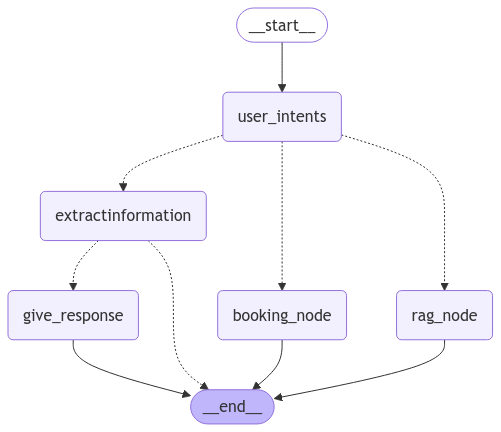

In [446]:
builder=StateGraph(getuserInfo)
builder.add_node
builder.add_node("user_intents",getuserintent)
builder.add_node("extractinformation",extractInformation)
builder.add_node("give_response",give_response)
builder.add_node("booking_node",booking_node)
builder.add_node("rag_node",rag_node)


builder.add_edge(START, "user_intents")
builder.add_conditional_edges("user_intents", userintents, ["extractinformation","booking_node","rag_node"])
builder.add_conditional_edges("extractinformation", should_continue, ["give_response", END])
builder.add_edge( "give_response",END)
builder.add_edge( "booking_node",END)
builder.add_edge( "rag_node",END)

memory=MemorySaver()
graph=builder.compile(checkpointer=memory)
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))


In [447]:

topic="""What is machine learning by the way my name is ravi?"""
thread = {"configurable": {"thread_id": "1"}}
#Run the graph 
for event in graph.stream({"input":topic},thread,
                          stream_mode="values"):
    
    infos = event.get('Contactinfo', '')
    if infos:
       print(infos["name"])
       print(infos["phone"])
       print(infos["email"])
       print(event["messages"])


        

In [448]:
thread = {"configurable": {"thread_id": "1"}}
op=graph.invoke({"input":"I want to book  appointment for monday"},thread)

In [449]:
op["messages"]

[HumanMessage(content='The provided text does not contain the answer to your question about machine learning.  It focuses on the Nepal Demographic and Health Survey (NDHS) and its methodology. \n', additional_kwargs={}, response_metadata={}, id='c45cd77a-7eba-4bcc-9991-9a57832a9607'),
 HumanMessage(content='Your date is booked for 2025-01-22', additional_kwargs={}, response_metadata={}, id='943a851e-31b1-45ec-bba1-fcdc90fbec5d')]

In [450]:
op["messages"][-1].content

'Your date is booked for 2025-01-22'

In [451]:
torch.cuda.is_available()

True

In [452]:
!nvcc --version

/bin/bash: line 1: nvcc: command not found


In [453]:
llm.invoke("do you know todaydate?")

AIMessage(content="I do not have access to real-time information, including the current date. To get today's date, you can check a calendar or your device's clock.\n", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 38, 'prompt_tokens': 15, 'total_tokens': 53, 'completion_time': 0.069090909, 'prompt_time': 7.606e-05, 'queue_time': 0.020566169000000002, 'total_time': 0.069166969}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'stop', 'logprobs': None}, id='run-cc824612-fbaf-46d9-a6c5-21d7f3cccdb3-0', usage_metadata={'input_tokens': 15, 'output_tokens': 38, 'total_tokens': 53})

In [454]:
from datetime import datetime

# Get today's date with the day of the week
today_date= datetime.today().strftime('%Y-%m-%d (%A)')


In [455]:
llm.invoke(f"todays date is {today_date}")

AIMessage(content="Thank you for providing the date! \n\nI'll keep that in mind as we chat.  \n\nIs there anything specific you'd like to do with this date information?  For example, do you want to:\n\n* Calculate the day of the week for a future date?\n* See how many days are left until a specific event?\n* Compare it to another date? \n\n\nLet me know! 😊 \n", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 91, 'prompt_tokens': 27, 'total_tokens': 118, 'completion_time': 0.165454545, 'prompt_time': 0.000134019, 'queue_time': 0.020575970000000002, 'total_time': 0.165588564}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'stop', 'logprobs': None}, id='run-4ccff3a3-c210-4ecc-81c9-535bb8a39a59-0', usage_metadata={'input_tokens': 27, 'output_tokens': 91, 'total_tokens': 118})

In [456]:
question="i want to book for tomorrow"

In [457]:
user_response_prompt="""The user wants to book an appointment.. 
Your task is to:
1. Parse this request and return ONLY a date in YYYY-MM-DD format
2. Today date is {today_date}
3. If the day has already passed this week, assume they mean next week
4. Return ONLY the date, no other text

The input user is this : {user_input}
"""

In [458]:
booking_node({"input":"i want to book for friday"})

{'booked_date': '2025-01-20',
 'messages': ['Your date is booked for 2025-01-20']}